In [2]:
from datetime import datetime, timedelta, date
import csv
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_auc_score, recall_score, precision_score
#roc_auc_score(y_true, y_scores)

### Reading in the data & convert date to datetime object

In [3]:
file_name = '../Full_Monthly.csv'

In [4]:
def get_data(file):
    df = pd.read_csv(file, index_col = 0)
    df['Date'] = pd.to_datetime(df['Date'])
    return df

In [5]:
df = get_data(file_name)

In [6]:
df.head()

,Date,Ticker,Sector,Industry,Cash From Operations,Current Market Cap,EBITDA Margin,Free Cash Flow,Gross Margin,Interest Expense,...,Yield.10.Yr.Vol.63,Yield.20.Yr.Vol.21,Yield.20.Yr.Vol.63,Yield.30.Yr.Vol.21,Yield.30.Yr.Vol.63,Total,OAS,Shiller.PE.Ratio,VIX.Value,VIX.VXV
1,1998-07-01,BAX,"Consumer, Non-cyclical",Healthcare-Products,146.000,15118.3532,25.5814,17.000,46.0888,39.000,...,0.100107,0.067771,0.117695,0.06957,0.126968,76.83215,72.402903,38.26,24.799999,NaN
2,1998-07-01,VOD,Communications,Telecommunications,NaN,256921.1418,NaN,NaN,NaN,NaN,...,0.100107,0.067771,0.117695,0.06957,0.126968,76.83215,78.340585,38.26,24.799999,NaN
3,1998-07-01,PXD,Energy,Oil&Gas,91.369,2398.8883,45.2357,-56.929,23.5375,41.017,...,0.100107,0.067771,0.117695,0.06957,0.126968,76.83215,147.188061,38.26,24.799999,NaN
4,1998-07-01,KMI,Energy,Pipelines,453.000,36519.0472,27.3650,-10.000,34.1947,297.000,...,0.100107,0.067771,0.117695,0.06957,0.126968,76.83215,113.533557,38.26,24.799999,NaN
5,1998-07-01,AZN,"Consumer, Non-cyclical",Pharmaceuticals,311.000,82119.0000,28.0482,-203.000,69.4947,33.000,...,0.100107,0.067771,0.117695,0.06957,0.126968,76.83215,60.176544,38.26,24.799999,NaN


### To stay consistent, the tickers will we focus on are RTN, DE, and PG

In [7]:
df_pg = df[df.Ticker == 'PG']
df_pg.head()

,Date,Ticker,Sector,Industry,Cash From Operations,Current Market Cap,EBITDA Margin,Free Cash Flow,Gross Margin,Interest Expense,...,Yield.10.Yr.Vol.63,Yield.20.Yr.Vol.21,Yield.20.Yr.Vol.63,Yield.30.Yr.Vol.21,Yield.30.Yr.Vol.63,Total,OAS,Shiller.PE.Ratio,VIX.Value,VIX.VXV
95,1998-07-01,PG,"Consumer, Non-cyclical",Cosmetics/Personal Care,1585.000000,122142.135700,16.567900,688.000000,42.804800,152.000000,...,0.100107,0.067771,0.117695,0.069570,0.126968,76.832150,52.293873,38.26,24.799999,NaN
205,1998-08-01,PG,"Consumer, Non-cyclical",Cosmetics/Personal Care,1483.840889,108794.405880,19.692273,796.989102,43.908357,153.224175,...,0.096231,0.055283,0.115589,0.055848,0.125602,83.081350,56.404484,35.42,44.279999,NaN
327,1998-09-01,PG,"Consumer, Non-cyclical",Cosmetics/Personal Care,1361.314649,98696.973968,22.301042,841.120122,44.857757,154.763327,...,0.102958,0.085732,0.091965,0.108142,0.104934,117.118731,81.900132,33.53,40.950001,NaN
462,1998-10-01,PG,"Consumer, Non-cyclical",Cosmetics/Personal Care,1196.054153,95100.137871,23.878604,755.534982,45.498844,156.932432,...,0.313982,0.078516,0.187200,0.092554,0.218705,108.267015,76.465481,33.77,28.049999,NaN
541,1998-11-01,PG,"Consumer, Non-cyclical",Cosmetics/Personal Care,986.337246,100017.218606,24.109228,511.630336,45.756897,159.888808,...,0.374456,0.168363,0.194161,0.134962,0.247209,137.672554,78.197225,37.37,26.010000,NaN


In [8]:
def add_oas_columns(df):
    """Takes a dataframe indexed by date and adds 3 additional columns related to OAS"""
    df['oas_pct_change'] = df.OAS.pct_change()
    df = df.drop(df.index[0]) #drop the first row since pct change makes first value NaN
    df['outlier'] = np.where((df.oas_pct_change > np.mean(df.oas_pct_change) + np.std(df.oas_pct_change))|(df.oas_pct_change < np.mean(df.oas_pct_change) - np.std(df.oas_pct_change)),1,0)
    #df['oas_rank'] = pd.cut(df.oas_pct_change, bins = num_of_bins,labels = list(range(num_of_bins)))
    #df['outlier'] = np.where((df.oas_rank == 0)|(df.oas_rank == num_of_bins-1),1,0)
    return df

In [10]:
df_PG = add_oas_columns(df_pg)
df_PG.head()

/Users/veronicahsieh/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Date,Ticker,Sector,Industry,Cash From Operations,Current Market Cap,EBITDA Margin,Free Cash Flow,Gross Margin,Interest Expense,...,Yield.20.Yr.Vol.63,Yield.30.Yr.Vol.21,Yield.30.Yr.Vol.63,Total,OAS,Shiller.PE.Ratio,VIX.Value,VIX.VXV,oas_pct_change,outlier
205,1998-08-01,PG,"Consumer, Non-cyclical",Cosmetics/Personal Care,1483.840889,108794.405880,19.692273,796.989102,43.908357,153.224175,...,0.115589,0.055848,0.125602,83.081350,56.404484,35.42,44.279999,NaN,0.078606,0
327,1998-09-01,PG,"Consumer, Non-cyclical",Cosmetics/Personal Care,1361.314649,98696.973968,22.301042,841.120122,44.857757,154.763327,...,0.091965,0.108142,0.104934,117.118731,81.900132,33.53,40.950001,NaN,0.452015,1
462,1998-10-01,PG,"Consumer, Non-cyclical",Cosmetics/Personal Care,1196.054153,95100.137871,23.878604,755.534982,45.498844,156.932432,...,0.187200,0.092554,0.218705,108.267015,76.465481,33.77,28.049999,NaN,-0.066357,0
541,1998-11-01,PG,"Consumer, Non-cyclical",Cosmetics/Personal Care,986.337246,100017.218606,24.109228,511.630336,45.756897,159.888808,...,0.194161,0.134962,0.247209,137.672554,78.197225,37.37,26.010000,NaN,0.022647,0
634,1998-12-01,PG,"Consumer, Non-cyclical",Cosmetics/Personal Care,815.392254,110112.495792,23.541495,237.578677,45.900699,163.108011,...,0.132408,0.072005,0.146521,117.358650,76.643962,38.82,24.420000,NaN,-0.019863,0


In [11]:
features = ['Date','Current Market Cap','Shares.Outstanding','Gross Margin','Interest Expense','Cash From Operations','EBITDA Margin','Net Debt','Total Current Liabilities','Total Assets','Revenue','Long Term Debt','Stock.Price','Net Income/Net Profit (Losses)','Short and Long Term Debt','Free Cash Flow']

In [12]:
def create_model_data(features_list,df):
    """Lags all the features by 1 month and merges it back to the outlier column"""
    df_features = df[features]
    df_features['Date'] = df_features['Date'] + pd.DateOffset(months=1)
    df_y = df[['Date','outlier']]
    df_lagged = pd.merge(df_features,df_y,on = 'Date')
    return df_lagged

In [13]:
model_data = create_model_data(features,df_PG)
model_data.head()

/Users/veronicahsieh/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,Date,Current Market Cap,Shares.Outstanding,Gross Margin,Interest Expense,Cash From Operations,EBITDA Margin,Net Debt,Total Current Liabilities,Total Assets,Revenue,Long Term Debt,Stock.Price,Net Income/Net Profit (Losses),Short and Long Term Debt,Free Cash Flow,outlier
0,1998-09-01,108794.405880,2682.6,43.908357,153.224175,1483.840889,19.692273,5888.137838,9757.182639,31720.566855,9310.013242,6003.047478,38.25000,888.544664,8729.007668,796.989102,1
1,1998-10-01,98696.973968,2682.6,44.857757,154.763327,1361.314649,22.301042,6117.348401,10188.100241,32382.683650,9375.383492,6209.170005,35.56250,1059.025956,9294.899648,841.120122,0
2,1998-11-01,95100.137871,2674.8,45.498844,156.932432,1196.054153,23.878604,6308.704413,10466.487770,32859.900323,9505.467760,6351.442634,44.34375,1165.380505,9626.560254,755.534982,0
3,1998-12-01,100017.218606,2674.8,45.756897,159.888808,986.337246,24.109228,6447.128215,10541.330812,33091.135604,9709.092595,6409.598679,43.81250,1188.298315,9653.631664,511.630336,0
4,1999-01-01,110112.495792,2651.8,45.900699,163.108011,815.392254,23.541495,6534.188979,10470.805869,33150.955837,9893.332120,6413.785136,45.65625,1163.618627,9507.950427,237.578677,0


In [15]:
model_data['outlier'].value_counts()

0    174
1     58
Name: outlier, dtype: int64

In [18]:
(174+58)

232

In [20]:
test = model_data.iloc[176:232]

In [21]:
train = model_data.iloc[0:175]
train

,Date,Current Market Cap,Shares.Outstanding,Gross Margin,Interest Expense,Cash From Operations,EBITDA Margin,Net Debt,Total Current Liabilities,Total Assets,Revenue,Long Term Debt,Stock.Price,Net Income/Net Profit (Losses),Short and Long Term Debt,Free Cash Flow,outlier
0,1998-09-01,108794.405880,2682.600,43.908357,153.224175,1483.840889,19.692273,5888.137838,9757.182639,31720.566855,9310.013242,6003.047478,38.250000,888.544664,8729.007668,796.989102,1
1,1998-10-01,98696.973968,2682.600,44.857757,154.763327,1361.314649,22.301042,6117.348401,10188.100241,32382.683650,9375.383492,6209.170005,35.562500,1059.025956,9294.899648,841.120122,0
2,1998-11-01,95100.137871,2674.800,45.498844,156.932432,1196.054153,23.878604,6308.704413,10466.487770,32859.900323,9505.467760,6351.442634,44.343750,1165.380505,9626.560254,755.534982,0
3,1998-12-01,100017.218606,2674.800,45.756897,159.888808,986.337246,24.109228,6447.128215,10541.330812,33091.135604,9709.092595,6409.598679,43.812500,1188.298315,9653.631664,511.630336,0
4,1999-01-01,110112.495792,2651.800,45.900699,163.108011,815.392254,23.541495,6534.188979,10470.805869,33150.955837,9893.332120,6413.785136,45.656250,1163.618627,9507.950427,237.578677,0
5,1999-02-01,120604.706490,2651.800,46.291863,165.881357,789.404799,22.957560,6575.954572,10342.597555,33150.585222,9937.762546,6407.772956,45.437500,1142.084394,9375.994763,103.920113,0
6,1999-03-01,127490.764539,2651.800,47.108023,167.620366,980.574408,22.929397,6575.826523,10232.322503,33168.028179,9762.343036,6423.424528,44.750000,1156.153465,9396.517373,233.613185,0
7,1999-04-01,130406.225034,2652.800,47.666579,168.298618,1302.189624,23.046230,6524.738990,10159.168685,33125.960176,9475.853945,6436.920172,48.968750,1152.786658,9485.115966,527.135435,0
8,1999-05-01,130049.240052,2652.800,47.033715,168.053832,1621.132016,22.610283,6409.985271,10125.845144,32901.695776,9242.217318,6408.179306,46.906250,1053.976984,9492.220017,819.993002,0
9,1999-06-01,127200.242091,2657.000,44.638554,166.913181,1825.934707,21.165510,6249.144463,10147.949348,32440.373761,9191.976110,6314.530752,46.687500,813.401390,9325.026080,978.263002,0


In [22]:
train_X = train[['Current Market Cap', 'Shares.Outstanding', 'Gross Margin',
       'Interest Expense', 'Cash From Operations', 'EBITDA Margin',
       'Net Debt', 'Total Current Liabilities', 'Total Assets', 'Revenue',
       'Long Term Debt', 'Stock.Price', 'Net Income/Net Profit (Losses)',
       'Short and Long Term Debt', 'Free Cash Flow']]

In [23]:
test_X = test[['Current Market Cap', 'Shares.Outstanding', 'Gross Margin',
       'Interest Expense', 'Cash From Operations', 'EBITDA Margin',
       'Net Debt', 'Total Current Liabilities', 'Total Assets', 'Revenue',
       'Long Term Debt', 'Stock.Price', 'Net Income/Net Profit (Losses)',
       'Short and Long Term Debt', 'Free Cash Flow']]

In [24]:
train_Y = train[['outlier']]

In [25]:
test_Y = test[['outlier']]

In [28]:
clf = LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial').fit(train_X, train_Y)

/Users/veronicahsieh/miniconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [26]:
clf2 = LogisticRegressionCV(cv=10, random_state=0,multi_class='multinomial').fit(train_X, train_Y)

/Users/veronicahsieh/miniconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [30]:
predicted_Y = clf.predict(test_X)

In [29]:
predicted_Y2 = clf2.predict(test_X)

In [31]:
def performance_metrics(actual,predicted):
    """Calculates the AUC, precision, and recall scores for the test set using sklearn metrics"""
    auc = roc_auc_score(actual, predicted)
    precision = list(precision_score(actual, predicted, average=None))
    recall = list(recall_score(actual, predicted,average =None))
    print("auc: {}".format(auc))
    print("precision: {}".format(precision))
    print("recall: {}".format(recall))
    return auc, precision, recall

In [32]:
test1 = performance_metrics(test_Y,predicted_Y2)
test1

auc: 0.4868421052631579
precision: [0.6727272727272727, 0.0]
recall: [0.9736842105263158, 0.0]


(0.4868421052631579, [0.6727272727272727, 0.0], [0.9736842105263158, 0.0])

In [42]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=4)
neigh.fit(train_X, train_Y)

/Users/veronicahsieh/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=4, p=2,
           weights='uniform')

In [43]:
predicted_Y3 = neigh.predict(test_X)

In [44]:
neigh.score(train_X,train_Y)

0.7885714285714286

In [46]:
test3 = performance_metrics(test_Y,predicted_Y3)
test3

auc: 0.4605263157894737
precision: [0.660377358490566, 0.0]
recall: [0.9210526315789473, 0.0]


(0.4605263157894737, [0.660377358490566, 0.0], [0.9210526315789473, 0.0])

In [48]:
from sklearn import metrics
from sklearn.ensemble import ExtraTreesClassifier
# fit an Extra Trees model to the data
model = ExtraTreesClassifier()
model.fit(train_X, train_Y)
# display the relative importance of each attribute
print(model.feature_importances_)

[0.06693686 0.05096736 0.06107227 0.06356864 0.06863043 0.05599084
 0.06820678 0.07132486 0.06397274 0.07331532 0.09243871 0.08358025
 0.06105999 0.05804327 0.06089168]


/Users/veronicahsieh/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


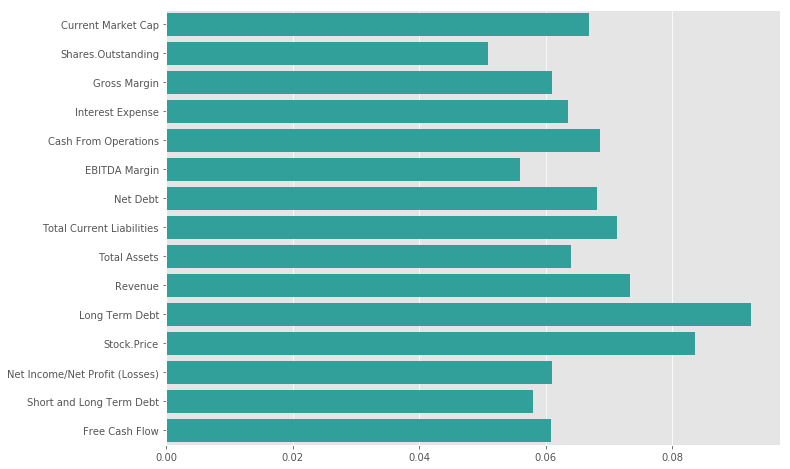

In [63]:
from matplotlib import pyplot
fig, ax = pyplot.subplots(figsize=(11,8))
sns.barplot(x = model.feature_importances_, y = train_X.columns.values, color="lightseagreen")

In [49]:
predicted_4 = model.predict(test_X)

In [51]:
test4 = performance_metrics(test_Y,predicted_4)
test4

auc: 0.6286549707602339
precision: [0.75, 0.5833333333333334]
recall: [0.868421052631579, 0.3888888888888889]


(0.6286549707602339,
 [0.75, 0.5833333333333334],
 [0.868421052631579, 0.3888888888888889])